# Classification Task

---






In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' #force Environment variable to synchronous computation
from google.colab import output
output.enable_custom_widget_manager()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from torch.nn import functional as F
import torchvision
from torchvision import datasets,transforms
import torchvision.transforms as transforms

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True)
m=len(train_dataset)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True)

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset.transform=transform
test_dataset.transform=transform

In [ ]:
class ConvNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1 = nn.Dropout2d(p=0.5)   
        self.fc1 = nn.Linear(in_features = 32*7*7, out_features = 96)
        self.drop2 = nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(in_features = 96, out_features = 10)

    def forward(self, x):

      # conv 1
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride = 2)

      # conv 2
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride = 2)

      # drop out 1
      x = self.drop1(x)

      # fc1
      x = x.reshape(-1, 32*7*7)
      x = self.fc1(x)
      x = F.relu(x)

      # drop out 2
      x = self.drop2(x)

      # fc2
      x = self.fc2(x)
      
      return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(42)
criterion = nn.CrossEntropyLoss()

dataset = ConcatDataset([train_dataset, test_dataset])

num_epochs=10
batch_size=128
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)

cuda:0


In [ ]:
foldperf={}

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

  print('Fold {}'.format(fold + 1))

  train_sampler = SubsetRandomSampler(train_idx)
  test_sampler = SubsetRandomSampler(val_idx)
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
  test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
  
  model = ConvNet()
  model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=0.002)

  history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

  for epoch in range(num_epochs):

    train_loss,train_correct=0.0,0
    model.train()
    for images, labels in train_loader:

      # Move data to device
      images,labels = images.to(device),labels.to(device)

      # Forward pass
      output = model(images)

      # Compute loss
      loss = criterion(output,labels)

      # Backpropagation
      model.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      #train_loss = loss.detach().cpu().numpy()

      train_loss += loss.item() * images.size(0)
      scores, predictions = torch.max(output.data, 1)
      train_correct += (predictions == labels).sum().item()

    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in test_loader:

      # Move data to device
      images,labels = images.to(device),labels.to(device)

      # Forward pass
      output = model(images)

      # Compute loss
      loss=criterion(output,labels)

      #test_loss = loss.detach().cpu().numpy()

      valid_loss+=loss.item()*images.size(0)
      scores, predictions = torch.max(output.data,1)
      val_correct+=(predictions == labels).sum().item()

    train_loss = train_loss / len(train_loader.sampler)
    train_acc = train_correct / len(train_loader.sampler) * 100
    test_loss = valid_loss / len(test_loader.sampler)
    test_acc = val_correct / len(test_loader.sampler) * 100

    print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1, num_epochs, train_loss, test_loss, train_acc, test_acc))

    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(test_acc)
    
  foldperf['fold{}'.format(fold+1)] = history

Fold 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch:1/10 AVG Training Loss:0.572 AVG Test Loss:0.361 AVG Training Acc 79.22 % AVG Test Acc 86.80 %
Epoch:2/10 AVG Training Loss:0.367 AVG Test Loss:0.295 AVG Training Acc 86.81 % AVG Test Acc 89.06 %
Epoch:3/10 AVG Training Loss:0.324 AVG Test Loss:0.272 AVG Training Acc 88.42 % AVG Test Acc 89.99 %
Epoch:4/10 AVG Training Loss:0.295 AVG Test Loss:0.263 AVG Training Acc 89.24 % AVG Test Acc 90.46 %
Epoch:5/10 AVG Training Loss:0.274 AVG Test Loss:0.264 AVG Training Acc 89.84 % AVG Test Acc 90.24 %
Epoch:6/10 AVG Training Loss:0.265 AVG Test Loss:0.244 AVG Training Acc 90.25 % AVG Test Acc 91.14 %
Epoch:7/10 AVG Training Loss:0.251 AVG Test Loss:0.234 AVG Training Acc 90.69 % AVG Test Acc 91.60 %
Epoch:8/10 AVG Training Loss:0.239 AVG Test Loss:0.225 AVG Training Acc 91.13 % AVG Test Acc 91.87 %
Epoch:9/10 AVG Training Loss:0.233 AVG Test Loss:0.233 AVG Training Acc 91.27 % AVG Test Acc 91.46 %
Epoch:10/10 AVG Training Loss:0.222 AVG Test Loss:0.218 AVG Training Acc 91.91 % AVG Test A

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
#k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.2f}".format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))     


Performance of 5 fold cross validation
Average Training Loss: 0.309 	 Average Test Loss: 0.265 	 Average Training Acc: 88.65 	 Average Test Acc: 90.22


In [ ]:
train_loss_log = []
val_loss_log = []
train_acc_log = []
val_acc_log = []

for i in range(num_epochs):
  
  train_loss_log.append((foldperf['fold1']['train_loss'][i] +
                         foldperf['fold2']['train_loss'][i] +
                         foldperf['fold3']['train_loss'][i] +
                         foldperf['fold4']['train_loss'][i] +
                         foldperf['fold5']['train_loss'][i]
                          ) / 5)
  
  val_loss_log.append((foldperf['fold1']['test_loss'][i] +
                       foldperf['fold2']['test_loss'][i] +
                       foldperf['fold3']['test_loss'][i] +
                       foldperf['fold4']['test_loss'][i] +
                       foldperf['fold5']['test_loss'][i]
                          ) / 5)
  
  train_acc_log.append((foldperf['fold1']['train_acc'][i] +
                        foldperf['fold2']['train_acc'][i] +
                        foldperf['fold3']['train_acc'][i] +
                        foldperf['fold4']['train_acc'][i] +
                        foldperf['fold5']['train_acc'][i]
                        ) / 5)
  
  val_acc_log.append((foldperf['fold1']['test_acc'][i] +
                      foldperf['fold2']['test_acc'][i] +
                      foldperf['fold3']['test_acc'][i] +
                      foldperf['fold4']['test_acc'][i] +
                      foldperf['fold5']['test_acc'][i]
                      ) / 5)

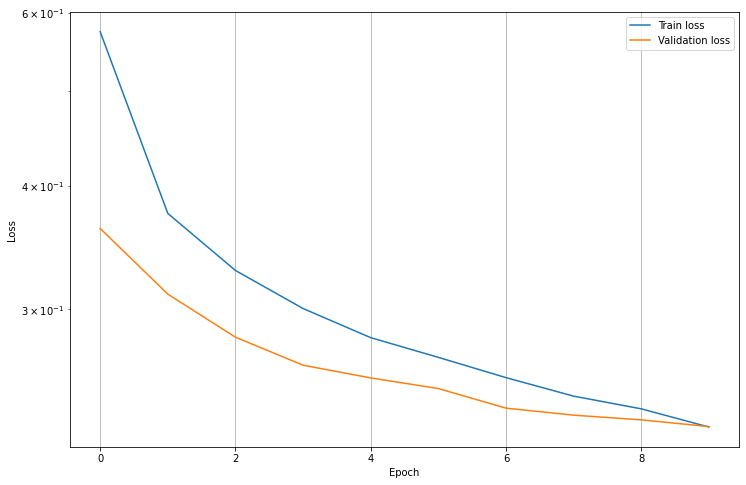

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

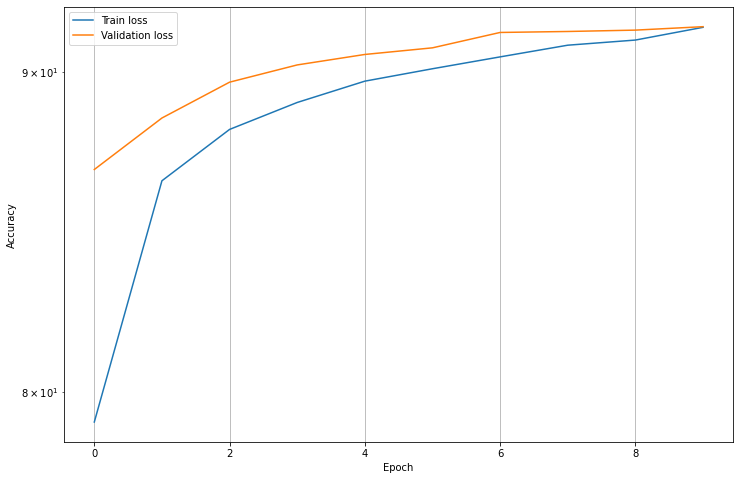

In [ ]:
# Plot losses
plt.figure(figsize=(12,8))
plt.semilogy(train_acc_log, label='Train loss')
plt.semilogy(val_acc_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

# Hyperparameter Tuning (Optuna)

In [ ]:
!pip install optuna
import optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class ConvNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.drop1 = nn.Dropout2d(p=0.5)   
        self.fc1 = nn.Linear(in_features = 32*7*7, out_features = 96)
        self.drop2 = nn.Dropout2d(p=0.1)
        self.fc2 = nn.Linear(in_features = 96, out_features = 10)



In [ ]:
class ConvNet(nn.Module):

    def __init__(self, trial):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        dropout_rate = trial.suggest_float("dropout_rate", 0, 0.5,step=0.1)
        self.drop1 = nn.Dropout2d(p=dropout_rate)
        fc2_input_dim = trial.suggest_int("fc2_input_dim", 32, 128,32)   
        self.fc1 = nn.Linear(in_features = 32*7*7, out_features = fc2_input_dim)
        dropout_rate2 = trial.suggest_float("dropout_rate2", 0, 0.3,step=0.1)
        self.drop2 = nn.Dropout2d(p=dropout_rate2)
        self.fc2 = nn.Linear(in_features = fc2_input_dim, out_features = 10)

    def forward(self, x):

      # conv 1
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride = 2)

      # conv 2
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size = 2, stride = 2)

      # drop out 1
      x = self.drop1(x)

      # fc1
      x = x.reshape(-1, 32*7*7)
      x = self.fc1(x)
      x = F.relu(x)

      # drop out 2
      x = self.drop2(x)

      # fc2
      x = self.fc2(x)
      
      return x

In [ ]:
def get_mnist(train_dataset,batch_size):

    train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
    # The dataloaders handle shuffling, batching, etc...
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    return train_loader, valid_loader

In [ ]:
def objective(trial):

    # Generate the model.
    model = ConvNet(trial).to(device)

    # Generate the optimizers.

    # try RMSprop and SGD
    '''
    optimizer_name = trial.suggest_categorical("optimizer", ["RMSprop", "SGD"])
    momentum = trial.suggest_float("momentum", 0.0, 1.0)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr,momentum=momentum)
    '''
    #try Adam, AdaDelta adn Adagrad
    
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "Adadelta","Adagrad"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1,log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    batch_size=trial.suggest_int("batch_size", 64, 256,step=64)

    criterion=nn.CrossEntropyLoss()

    # Get the MNIST imagesset.
    train_loader, valid_loader = get_mnist(train_dataset,batch_size)
    
    # Training of the model.
    for epoch in range(num_epochs):
        model.train()
       
        for batch_idx, (images, labels) in enumerate(train_loader):
            # Limiting training images for faster epochs.
            #if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
            #    break

            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(valid_loader):
                # Limiting validation images.
               # if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                #    break
                images, labels = images.to(device), labels.to(device)
                output = model(images)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(labels.view_as(pred)).sum().item()

        accuracy = correct / len(valid_loader.dataset)


        trial.report(accuracy, epoch)
        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2022-10-26 10:30:42,228] A new study created in memory with name: no-name-c45954c4-9943-4e41-a413-349af65f422a
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning:

dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).

[I 2022-10-26 10:32:13,919] Trial 0 finished with value: 0.8735 and parameters: {'dropout_rate': 0.2, 'fc2_input_dim': 128, 'dropout_rate2': 0.3, 'optimizer': 'Adam', 'lr': 9.331442593456361e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8735.
[I 2022-10-26 10:33:28,780] Trial 1 finished with value: 0.12333333333333334 and parameters: {'dropout_rate': 0.30000000000000004, 'fc2_input_dim': 64, 'dropout_rate2': 0.0, 'optimizer': 

Accuracy: 0.9131666666666667
Best hyperparameters: {'dropout_rate': 0.4, 'fc2_input_dim': 64, 'dropout_rate2': 0.3, 'optimizer': 'Adam', 'lr': 0.002826881579075775, 'batch_size': 256}


In [ ]:
#df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete','duration','number'], axis=1)
df = study.trials_dataframe()
df

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_rate,params_dropout_rate2,params_fc2_input_dim,params_lr,params_optimizer,state
0,0,0.873500,2022-10-26 10:30:42.230637,2022-10-26 10:32:13.919141,0 days 00:01:31.688504,64,0.2,0.3,128,0.000093,Adam,COMPLETE
1,1,0.123333,2022-10-26 10:32:13.921216,2022-10-26 10:33:28.780298,0 days 00:01:14.859082,128,0.3,0.0,64,0.000197,Adadelta,COMPLETE
2,2,0.867167,2022-10-26 10:33:28.782292,2022-10-26 10:34:31.202880,0 days 00:01:02.420588,256,0.1,0.1,128,0.002692,Adagrad,COMPLETE
3,3,0.905167,2022-10-26 10:34:31.205097,2022-10-26 10:35:38.830939,0 days 00:01:07.625842,192,0.5,0.0,64,0.008767,Adam,COMPLETE
4,4,0.832583,2022-10-26 10:35:38.832823,2022-10-26 10:36:40.848601,0 days 00:01:02.015778,256,0.4,0.0,64,0.001637,Adagrad,COMPLETE
5,5,0.182583,2022-10-26 10:36:40.850577,2022-10-26 10:36:47.987359,0 days 00:00:07.136782,128,0.4,0.3,128,0.000022,Adagrad,PRUNED
6,6,0.135417,2022-10-26 10:36:47.989320,2022-10-26 10:36:55.769931,0 days 00:00:07.780611,192,0.4,0.2,64,0.001002,Adadelta,PRUNED
7,7,0.909167,2022-10-26 10:36:55.771809,2022-10-26 10:37:59.283259,0 days 00:01:03.511450,256,0.5,0.2,32,0.003518,Adam,COMPLETE
8,8,0.898750,2022-10-26 10:37:59.285322,2022-10-26 10:39:00.928672,0 days 00:01:01.643350,256,0.0,0.1,128,0.008907,Adagrad,COMPLETE
9,9,0.884417,2022-10-26 10:39:00.930491,2022-10-26 10:40:31.560239,0 days 00:01:30.629748,64,0.5,0.2,96,0.008748,Adam,COMPLETE


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['batch_size', 'lr'])

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)